# Introduction to Neural Nets

This Colab builds a deep neural network to perform more sophisticated linear regression than the earlier Colabs.

## Learning Objectives:

After doing this Colab, you'll know how to do the following:

  * Create a simple deep neural network.
  * Tune the hyperparameters for a simple deep neural network.

## The Dataset
  
Like several of the previous Colabs, this Colab uses the [California Housing Dataset](https://developers.google.com/machine-learning/crash-course/california-housing-data-description).

## Import relevant modules

The following hidden code cell imports the necessary code to run the code in the rest of this Colaboratory.

In [1]:
#@title Import relevant modules
import numpy as np
import pandas as pd
import tensorflow as tf

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import math
from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Imported modules.")

Imported modules.


## Load the dataset

Like most of the previous Colab exercises, this exercise uses the California Housing Dataset.  The following code cell loads the separate .csv files and creates the following two pandas DataFrames:

* `train_df`, which contains the training set
* `test_df`, which contains the test set
   

In [2]:
# Load the dataset
orign_train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

# Shuffle the examples
orign_train_df = orign_train_df.reindex(np.random.permutation(orign_train_df.index))

## Normalize values

When building a model with multiple features, the values of each feature should cover roughly the same range.  The following code cell normalizes datasets by converting each raw value to its Z-score. (For more information about Z-scores, see the Classification exercise.)

In [3]:
# Calculate the Z-scores of each column in the training set:
train_df_mean = orign_train_df.mean()
train_df_std = orign_train_df.std()
train_df_norm = (orign_train_df - train_df_mean)/train_df_std

# Calculate the Z-scores of each column in the test set.
test_df_mean = test_df.mean()
test_df_std = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

print("Normalized the values.")

Normalized the values.


In [4]:
resolution_in_Zs = 0.3  # 3/10 of a standard deviation.

feature_columns = []

# Create a bucket feature column for latitude.
latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(np.arange(int(min(train_df_norm['latitude'])), 
                                     int(max(train_df_norm['latitude'])), 
                                     resolution_in_Zs))
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, latitude_boundaries)

# Create a bucket feature column for longitude.
longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(int(min(train_df_norm['longitude'])), 
                                      int(max(train_df_norm['longitude'])), 
                                      resolution_in_Zs))

# Represent median_income as a floating-point value.
median_income = tf.feature_column.numeric_column("median_income")
feature_columns.append(median_income)

# Represent population as a floating-point value.
population = tf.feature_column.numeric_column("population")
feature_columns.append(population)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
# my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
feature_columns

[NumericColumn(key='median_income', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='population', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [5]:
resolution_in_Zs = 0.3  

# Create a new empty list that will eventually hold the generated feature column.
feature_columns = []

# Create a bucket feature column for latitude.
# latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(np.arange(int(min(train_df_norm['latitude'])), 
                                     int(max(train_df_norm['latitude'])), 
                                     resolution_in_Zs))

print("latitude_boundaries: ", latitude_boundaries)
# latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, 
#                                                latitude_boundaries)
feature_columns.append("latitude")

# Create a bucket feature column for longitude.
# longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(int(min(train_df_norm['longitude'])), 
                                      int(max(train_df_norm['longitude'])), 
                                      resolution_in_Zs))
print("longitude_boundaries: ", longitude_boundaries)
# longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, 
#                                                 longitude_boundaries)
feature_columns.append("longitude")

# Convert the list of feature columns into a layer that will ultimately become
# part of the model. Understanding layers is not important right now.
# buckets_feature_layer = layers.DenseFeatures(feature_columns)

feature_columns = ["latitude", "longitude", "median_income", "population"]
feature_columns

latitude_boundaries:  [-1.0, -0.7, -0.3999999999999999, -0.09999999999999987, 0.20000000000000018, 0.5000000000000002, 0.8000000000000003, 1.1000000000000005, 1.4000000000000004, 1.7000000000000002]
longitude_boundaries:  [-2.0, -1.7, -1.4, -1.0999999999999999, -0.7999999999999998, -0.4999999999999998, -0.19999999999999973, 0.10000000000000053, 0.40000000000000036, 0.7000000000000002, 1.0000000000000004, 1.3000000000000007, 1.6000000000000005, 1.9000000000000004]


['latitude', 'longitude', 'median_income', 'population']

In [6]:
def latitude_app(val, l):
    
    if val < l[0]: return 0
    
    for idx, item in enumerate(l[1:]):
        if val < item: return idx
    
    if val > l[-1]: return len(l) + 1
    

def longitude_app(val, l):
    if val < l[0]: return 0
    
    for idx, item in enumerate(l[1:]):
        if val < item: return idx
    
    if val > l[-1]: return len(l) + 1  

train_df_norm['latitude'] = train_df_norm.apply(lambda r: latitude_app(r['latitude'], latitude_boundaries), axis=1)
train_df_norm['longitude'] = train_df_norm.apply(lambda r: longitude_app(r['longitude'], longitude_boundaries), axis=1) 

test_df_norm['latitude'] = test_df_norm.apply(lambda r: latitude_app(r['latitude'], latitude_boundaries), axis=1)
test_df_norm['longitude'] = test_df_norm.apply(lambda r: longitude_app(r['longitude'], longitude_boundaries), axis=1) 

In [7]:
train_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
8441,8,1,0.5,-0.4,-0.5,-0.3,-0.4,0.6,0.1
6578,8,0,-0.9,-0.1,1.6,1.4,1.3,-1.1,-0.3
14521,2,6,1.9,-0.6,-0.8,-0.8,-0.7,0.0,0.1
10217,6,4,0.4,-0.6,-0.7,-0.6,-0.7,-0.5,-1.0
10037,6,5,-1.1,0.3,0.4,-0.2,0.3,-0.9,-1.2


In [8]:
len(train_df_norm.columns)

9

## Build a linear regression model as a baseline

Before creating a deep neural net, find a [baseline](https://developers.google.com/machine-learning/glossary/#baseline) loss by running a simple linear regression model that uses the feature layer you just created. 


In [9]:
from torch import nn

class Sequential(nn.Module):
    def __init__(self):
        super(Sequential, self).__init__()
        self.hid = nn.Sequential(
                    nn.Linear(len(feature_columns), 1)                    
                )
    def forward(self, x):
        out = self.hid(x)
        return out
    
Sequential()

Sequential(
  (hid): Sequential(
    (0): Linear(in_features=4, out_features=1, bias=True)
  )
)

In [10]:
# The following variables are the hyperparameters.
learning_rate = 0.01
n_epochs = 15
batch_size = 1000
label_name = "median_house_value"


# train_df, valid_df = train_test_split(train_df_norm, test_size=0.2)

from sklearn.model_selection import train_test_split

tfm = transforms.Compose([
    transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]
])

class MyDataset(Dataset):
 
    def __init__(self, df, tfm):
       
        self.transform = tfm
        x=df[feature_columns].values
        y=df[[label_name]].values

        self.x_train=torch.tensor(x,dtype=torch.float32)
        self.y_train=torch.tensor(y,dtype=torch.float32)    
           

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self,idx):
        return self.x_train[idx],self.y_train[idx]

train_ds = MyDataset(train_df_norm, tfm)
# valid_ds = MyDataset(valid_df, tfm)
test_ds = MyDataset(test_df_norm, tfm)


train_loader=DataLoader(train_ds,batch_size=batch_size,shuffle=False)

# valid_loader=DataLoader(valid_ds,batch_size=batch_size,shuffle=False)

test_loader=DataLoader(test_ds,batch_size=batch_size,shuffle=False)

In [11]:
model = Sequential()

optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.1, eps=1e-08, 
#                                 weight_decay=0.1, momentum=0.2, centered=False)
loss_func = nn.MSELoss()   
    
    
epoch_train_loss = []

epoch_valid_loss = []

    
for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []    
    
    # for batch in tqdm(trainloader):
    for batch in tqdm(train_loader):
        X, y = batch          
        # print(X)
        y_hat = model(X)
        loss = loss_func(y_hat, y) #rmse
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
        
        # Record the loss and accuracy.
        train_loss.append(loss.item())
        
    train_loss = sum(train_loss) / len(train_loss)
    
    epoch_train_loss.append(train_loss)   
  
    # Print the information.
    print(f"[ Epoch | {epoch + 1:03d}/{n_epochs:03d} ] \
          train_loss = {train_loss:.5f} mean_squared_error = {train_loss:.5f}")
    
print("Defined the build_model and train_model functions.")


[ Epoch | 001/015 ]           train_loss = 1.53477 mean_squared_error = 1.53477



[ Epoch | 002/015 ]           train_loss = 0.51622 mean_squared_error = 0.51622



[ Epoch | 003/015 ]           train_loss = 0.51131 mean_squared_error = 0.51131



[ Epoch | 004/015 ]           train_loss = 0.50687 mean_squared_error = 0.50687



[ Epoch | 005/015 ]           train_loss = 0.50233 mean_squared_error = 0.50233



[ Epoch | 006/015 ]           train_loss = 0.49769 mean_squared_error = 0.49769



[ Epoch | 007/015 ]           train_loss = 0.49297 mean_squared_error = 0.49297



[ Epoch | 008/015 ]           train_loss = 0.48820 mean_squared_error = 0.48820



[ Epoch | 009/015 ]           train_loss = 0.48341 mean_squared_error = 0.48341



[ Epoch | 010/015 ]           train_loss = 0.47862 mean_squared_error = 0.47862



[ Epoch | 011/015 ]           train_loss = 0.47388 mean_squared_error = 0.47388



[ Epoch | 012/015 ]           train_loss = 0.46921 mean_squared_error = 0.46921



[ Epoch | 013/015 ]           train_loss = 0.46465 mean_squared_error = 0.46465



[ Epoch | 014/015 ]           train_loss = 0.46023 mean_squared_error = 0.46023



[ Epoch | 015/015 ]           train_loss = 0.45598 mean_squared_error = 0.45598
Defined the build_model and train_model functions.


In [12]:
model.eval()

# These are used to record information in validation.
test_loss = []

for batch in tqdm(test_loader):
    X, y = batch          
    # print(X)
    y_hat = model(X)
    loss = loss_func(y_hat, y) #rmse
    
    # Record the loss and accuracy.
    test_loss.append(loss.item())
    
    
 # The average loss and accuracy for entire validation set is the average of the recorded values.
test_loss = sum(test_loss) / len(test_loss)

# Print the information.
print(f"test_loss = {test_loss:.5f} mean_squared_error = {test_loss:.5f}")    


test_loss = 1.09044 mean_squared_error = 1.09044


## Define a deep neural net model

The `create_model` function defines the topography of the deep neural net, specifying the following:

* The number of [layers](https://developers.google.com/machine-learning/glossary/#layer) in the deep neural net.
* The number of [nodes](https://developers.google.com/machine-learning/glossary/#node) in each layer.

The `create_model` function also defines the [activation function](https://developers.google.com/machine-learning/glossary/#activation_function) of each layer.

In [13]:
from torch import nn

class Sequential(nn.Module):
    def __init__(self):
        super(Sequential, self).__init__()
        self.hid = nn.Sequential(
                    nn.Linear(len(feature_columns), 20) ,                   
                    nn.Linear(20, 12),
                    nn.Linear(12, 1),
                )
    def forward(self, x):
        out = self.hid(x)
        return out
    
Sequential()

Sequential(
  (hid): Sequential(
    (0): Linear(in_features=4, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=12, bias=True)
    (2): Linear(in_features=12, out_features=1, bias=True)
  )
)

## Define a training function

The `train_model` function trains the model from the input features and labels. The [tf.keras.Model.fit](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#fit) method performs the actual training. The `x` parameter of the `fit` method is very flexible, enabling you to pass feature data in a variety of ways. The following implementation passes a Python dictionary in which:

* The *keys* are the names of each feature (for example, `longitude`, `latitude`, and so on).
* The *value* of each key is a NumPy array containing the values of that feature. 

**Note:** Although you are passing *every* feature to `model.fit`, most of those values will be ignored. Only the features accessed by `my_feature_layer` will actually be used to train the model.

In [14]:
# The following variables are the hyperparameters.
learning_rate = 0.01
n_epochs = 20
batch_size = 1000


[ Epoch | 001/020 ]           train_loss = 2.62729 mean_squared_error = 2.62729



[ Epoch | 002/020 ]           train_loss = 0.51024 mean_squared_error = 0.51024



[ Epoch | 003/020 ]           train_loss = 0.50279 mean_squared_error = 0.50279



[ Epoch | 004/020 ]           train_loss = 0.49557 mean_squared_error = 0.49557



[ Epoch | 005/020 ]           train_loss = 0.48821 mean_squared_error = 0.48821



[ Epoch | 006/020 ]           train_loss = 0.48143 mean_squared_error = 0.48143



[ Epoch | 007/020 ]           train_loss = 0.47856 mean_squared_error = 0.47856



[ Epoch | 008/020 ]           train_loss = 0.47646 mean_squared_error = 0.47646



[ Epoch | 009/020 ]           train_loss = 0.47459 mean_squared_error = 0.47459



[ Epoch | 010/020 ]           train_loss = 0.46949 mean_squared_error = 0.46949



[ Epoch | 011/020 ]           train_loss = 0.47939 mean_squared_error = 0.47939



[ Epoch | 012/020 ]           train_loss = 0.47365 mean_squared_error = 0.47365



[ Epoch | 013/020 ]           train_loss = 0.44962 mean_squared_error = 0.44962



[ Epoch | 014/020 ]           train_loss = 0.44867 mean_squared_error = 0.44867



[ Epoch | 015/020 ]           train_loss = 0.43659 mean_squared_error = 0.43659



[ Epoch | 016/020 ]           train_loss = 0.49585 mean_squared_error = 0.49585



[ Epoch | 017/020 ]           train_loss = 0.43886 mean_squared_error = 0.43886



[ Epoch | 018/020 ]           train_loss = 0.44290 mean_squared_error = 0.44290



[ Epoch | 019/020 ]           train_loss = 0.44364 mean_squared_error = 0.44364



[ Epoch | 020/020 ]           train_loss = 0.47135 mean_squared_error = 0.47135
Defined the build_model and train_model functions.


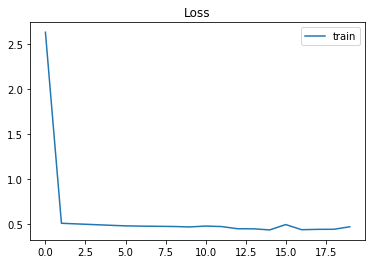

In [15]:
model = Sequential()

optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.1, eps=1e-08, 
#                                 weight_decay=0.1, momentum=0.2, centered=False)
loss_func = nn.MSELoss()   
    
    
epoch_train_loss = []

epoch_valid_loss = []

    
for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []    
    
    # for batch in tqdm(trainloader):
    for batch in tqdm(train_loader):
        X, y = batch          
        # print(X)
        y_hat = model(X)
        loss = loss_func(y_hat, y) #rmse
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
        
        # Record the loss and accuracy.
        train_loss.append(loss.item())
        
    train_loss = sum(train_loss) / len(train_loss)
    
    epoch_train_loss.append(train_loss)   
  
    # Print the information.
    print(f"[ Epoch | {epoch + 1:03d}/{n_epochs:03d} ] \
          train_loss = {train_loss:.5f} mean_squared_error = {train_loss:.5f}")
    
print("Defined the build_model and train_model functions.")



import matplotlib.pyplot as plt

# Loss curve
plt.plot(epoch_train_loss)
plt.title('Loss')
plt.legend(['train'])
plt.savefig('loss.png')
plt.show()

In [16]:
model.eval()

# These are used to record information in validation.
test_loss = []

for batch in tqdm(test_loader):
    X, y = batch          
    # print(X)
    y_hat = model(X)
    loss = loss_func(y_hat, y) #rmse
    
    # Record the loss and accuracy.
    test_loss.append(loss.item())
    
    
 # The average loss and accuracy for entire validation set is the average of the recorded values.
test_loss = sum(test_loss) / len(test_loss)

# Print the information.
print(f"test_loss = {test_loss:.5f} mean_squared_error = {test_loss:.5f}")    


test_loss = 2.19567 mean_squared_error = 2.19567


## Task 3: Regularize the deep neural network (if you have enough time)

Notice that the model's loss against the test set is *much higher* than the loss against the training set.  In other words, the deep neural network is [overfitting](https://developers.google.com/machine-learning/glossary/#overfitting) to the data in the training set.  To reduce overfitting, regularize the model.  The course has suggested several different ways to regularize a model, including:

  * [L1 regularization](https://developers.google.com/machine-learning/glossary/#L1_regularization)
  * [L2 regularization](https://developers.google.com/machine-learning/glossary/#L2_regularization)
  * [Dropout regularization](https://developers.google.com/machine-learning/glossary/#dropout_regularization)

Your task is to experiment with one or more regularization mechanisms to bring the test loss closer to the training loss (while still keeping test loss relatively low).  

**Note:** When you add a regularization function to a model, you might need to tweak other hyperparameters. 

### Implementing L1 or L2 regularization

To use L1 or L2 regularization on a hidden layer, specify the `kernel_regularizer` argument to [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense). Assign one of the following methods to this argument:

* `tf.keras.regularizers.l1` for L1 regularization
* `tf.keras.regularizers.l2` for L2 regularization

Each of the preceding methods takes an `l` parameter, which adjusts the [regularization rate](https://developers.google.com/machine-learning/glossary/#regularization_rate). Assign a decimal value between 0 and 1.0 to `l`; the higher the decimal, the greater the regularization. For example, the following applies L2 regularization at a strength of 0.01. 

```
model.add(tf.keras.layers.Dense(units=20, 
                                activation='relu',
                                kernel_regularizer=tf.keras.regularizers.l2(l=0.01),
                                name='Hidden1'))
```



In [17]:
# https://pyquestions.com/adding-l1-l2-regularization-in-pytorch
# https://github.com/szymonmaszke/torchlayers/blob/master/torchlayers/regularization.py

class L1(torch.nn.Module):
    def __init__(self, module, weight_decay):
        super().__init__()
        self.module = module
        self.weight_decay = weight_decay

        # Backward hook is registered on the specified module
        self.hook = self.module.register_full_backward_hook(self._weight_decay_hook)

    # Not dependent on backprop incoming values, placeholder
    def _weight_decay_hook(self, *_):
        for param in self.module.parameters():
            # If there is no gradient or it was zeroed out
            # Zeroed out using optimizer.zero_grad() usually
            # Turn on if needed with grad accumulation/more safer way
            # if param.grad is None or torch.all(param.grad == 0.0):

            # Apply regularization on it
            param.grad = self.regularize(param)

    def regularize(self, parameter):
        # L1 regularization formula
        return self.weight_decay * torch.sign(parameter.data)

    def forward(self, *args, **kwargs):
        # Simply forward and args and kwargs to module
        return self.module(*args, **kwargs)
    
class L2(torch.nn.Module):
    def __init__(self, module, weight_decay):
        super().__init__()
        self.module = module
        self.weight_decay = weight_decay

        # Backward hook is registered on the specified module
        self.hook = self.module.register_full_backward_hook(self._weight_decay_hook)

    # Not dependent on backprop incoming values, placeholder
    def _weight_decay_hook(self, *_):
        for param in self.module.parameters():
            # If there is no gradient or it was zeroed out
            # Zeroed out using optimizer.zero_grad() usually
            # Turn on if needed with grad accumulation/more safer way
            # if param.grad is None or torch.all(param.grad == 0.0):

            # Apply regularization on it
            param.grad = self.regularize(param)

    def regularize(self, parameter):
        # L2 regularization formula
        return self.weight_decay * parameter.data

    def forward(self, *args, **kwargs):
        # Simply forward and args and kwargs to module
        return self.module(*args, **kwargs)    

### Implementing Dropout regularization

You implement dropout regularization as a separate layer in the topography. For example, the following code demonstrates how to add a dropout regularization layer between the first hidden layer and the second hidden layer:

```
model.add(tf.keras.layers.Dense( *define first hidden layer*)
 
model.add(tf.keras.layers.Dropout(rate=0.25))

model.add(tf.keras.layers.Dense( *define second hidden layer*)
```

The `rate` parameter to [tf.keras.layers.Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) specifies the fraction of nodes that the model should drop out during training. 


In [18]:
learning_rate = 0.007
n_epochs = 140
batch_size = 1000

In [19]:
from torch import nn

class Sequential(nn.Module):
    def __init__(self):
        super(Sequential, self).__init__()
        self.hid = nn.Sequential(
                    L2(nn.Linear(len(feature_columns), 20), weight_decay=0.01) ,   
                    nn.Dropout(0.25),
                    nn.Linear(20, 12),
                    nn.Linear(12, 1),
                )
    def forward(self, x):
        out = self.hid(x)
        return out
    
Sequential()

Sequential(
  (hid): Sequential(
    (0): L2(
      (module): Linear(in_features=4, out_features=20, bias=True)
    )
    (1): Dropout(p=0.25, inplace=False)
    (2): Linear(in_features=20, out_features=12, bias=True)
    (3): Linear(in_features=12, out_features=1, bias=True)
  )
)


[ Epoch | 001/140 ]           train_loss = 1.26312 mean_squared_error = 1.26312



[ Epoch | 002/140 ]           train_loss = 0.67917 mean_squared_error = 0.67917



[ Epoch | 003/140 ]           train_loss = 0.55581 mean_squared_error = 0.55581



[ Epoch | 004/140 ]           train_loss = 0.53115 mean_squared_error = 0.53115



[ Epoch | 005/140 ]           train_loss = 0.51276 mean_squared_error = 0.51276



[ Epoch | 006/140 ]           train_loss = 0.50196 mean_squared_error = 0.50196



[ Epoch | 007/140 ]           train_loss = 0.49156 mean_squared_error = 0.49156



[ Epoch | 008/140 ]           train_loss = 0.48361 mean_squared_error = 0.48361



[ Epoch | 009/140 ]           train_loss = 0.47536 mean_squared_error = 0.47536



[ Epoch | 010/140 ]           train_loss = 0.46976 mean_squared_error = 0.46976



[ Epoch | 011/140 ]           train_loss = 0.46731 mean_squared_error = 0.46731



[ Epoch | 012/140 ]           train_loss = 0.46011 mean_squared_error = 0.46011



[ Epoch | 013/140 ]           train_loss = 0.45770 mean_squared_error = 0.45770



[ Epoch | 014/140 ]           train_loss = 0.45244 mean_squared_error = 0.45244



[ Epoch | 015/140 ]           train_loss = 0.45248 mean_squared_error = 0.45248



[ Epoch | 016/140 ]           train_loss = 0.44944 mean_squared_error = 0.44944



[ Epoch | 017/140 ]           train_loss = 0.45184 mean_squared_error = 0.45184



[ Epoch | 018/140 ]           train_loss = 0.44729 mean_squared_error = 0.44729



[ Epoch | 019/140 ]           train_loss = 0.44890 mean_squared_error = 0.44890



[ Epoch | 020/140 ]           train_loss = 0.44553 mean_squared_error = 0.44553



[ Epoch | 021/140 ]           train_loss = 0.44306 mean_squared_error = 0.44306



[ Epoch | 022/140 ]           train_loss = 0.44331 mean_squared_error = 0.44331



[ Epoch | 023/140 ]           train_loss = 0.44129 mean_squared_error = 0.44129



[ Epoch | 024/140 ]           train_loss = 0.44211 mean_squared_error = 0.44211



[ Epoch | 025/140 ]           train_loss = 0.44121 mean_squared_error = 0.44121



[ Epoch | 026/140 ]           train_loss = 0.44073 mean_squared_error = 0.44073



[ Epoch | 027/140 ]           train_loss = 0.44289 mean_squared_error = 0.44289



[ Epoch | 028/140 ]           train_loss = 0.44107 mean_squared_error = 0.44107



[ Epoch | 029/140 ]           train_loss = 0.44311 mean_squared_error = 0.44311



[ Epoch | 030/140 ]           train_loss = 0.44152 mean_squared_error = 0.44152



[ Epoch | 031/140 ]           train_loss = 0.43978 mean_squared_error = 0.43978



[ Epoch | 032/140 ]           train_loss = 0.43934 mean_squared_error = 0.43934



[ Epoch | 033/140 ]           train_loss = 0.43719 mean_squared_error = 0.43719



[ Epoch | 034/140 ]           train_loss = 0.43837 mean_squared_error = 0.43837



[ Epoch | 035/140 ]           train_loss = 0.43743 mean_squared_error = 0.43743



[ Epoch | 036/140 ]           train_loss = 0.44006 mean_squared_error = 0.44006



[ Epoch | 037/140 ]           train_loss = 0.43835 mean_squared_error = 0.43835



[ Epoch | 038/140 ]           train_loss = 0.43626 mean_squared_error = 0.43626



[ Epoch | 039/140 ]           train_loss = 0.43437 mean_squared_error = 0.43437



[ Epoch | 040/140 ]           train_loss = 0.43376 mean_squared_error = 0.43376



[ Epoch | 041/140 ]           train_loss = 0.43842 mean_squared_error = 0.43842



[ Epoch | 042/140 ]           train_loss = 0.43673 mean_squared_error = 0.43673



[ Epoch | 043/140 ]           train_loss = 0.43500 mean_squared_error = 0.43500



[ Epoch | 044/140 ]           train_loss = 0.43608 mean_squared_error = 0.43608



[ Epoch | 045/140 ]           train_loss = 0.43443 mean_squared_error = 0.43443



[ Epoch | 046/140 ]           train_loss = 0.43382 mean_squared_error = 0.43382



[ Epoch | 047/140 ]           train_loss = 0.43273 mean_squared_error = 0.43273



[ Epoch | 048/140 ]           train_loss = 0.43331 mean_squared_error = 0.43331



[ Epoch | 049/140 ]           train_loss = 0.43469 mean_squared_error = 0.43469



[ Epoch | 050/140 ]           train_loss = 0.43319 mean_squared_error = 0.43319



[ Epoch | 051/140 ]           train_loss = 0.43652 mean_squared_error = 0.43652



[ Epoch | 052/140 ]           train_loss = 0.43648 mean_squared_error = 0.43648



[ Epoch | 053/140 ]           train_loss = 0.43207 mean_squared_error = 0.43207



[ Epoch | 054/140 ]           train_loss = 0.43265 mean_squared_error = 0.43265



[ Epoch | 055/140 ]           train_loss = 0.43435 mean_squared_error = 0.43435



[ Epoch | 056/140 ]           train_loss = 0.43313 mean_squared_error = 0.43313



[ Epoch | 057/140 ]           train_loss = 0.43343 mean_squared_error = 0.43343



[ Epoch | 058/140 ]           train_loss = 0.43308 mean_squared_error = 0.43308



[ Epoch | 059/140 ]           train_loss = 0.43202 mean_squared_error = 0.43202



[ Epoch | 060/140 ]           train_loss = 0.43335 mean_squared_error = 0.43335



[ Epoch | 061/140 ]           train_loss = 0.43163 mean_squared_error = 0.43163



[ Epoch | 062/140 ]           train_loss = 0.43246 mean_squared_error = 0.43246



[ Epoch | 063/140 ]           train_loss = 0.43329 mean_squared_error = 0.43329



[ Epoch | 064/140 ]           train_loss = 0.43112 mean_squared_error = 0.43112



[ Epoch | 065/140 ]           train_loss = 0.43195 mean_squared_error = 0.43195



[ Epoch | 066/140 ]           train_loss = 0.43408 mean_squared_error = 0.43408



[ Epoch | 067/140 ]           train_loss = 0.43089 mean_squared_error = 0.43089



[ Epoch | 068/140 ]           train_loss = 0.43126 mean_squared_error = 0.43126



[ Epoch | 069/140 ]           train_loss = 0.43206 mean_squared_error = 0.43206



[ Epoch | 070/140 ]           train_loss = 0.43320 mean_squared_error = 0.43320



[ Epoch | 071/140 ]           train_loss = 0.43218 mean_squared_error = 0.43218



[ Epoch | 072/140 ]           train_loss = 0.43244 mean_squared_error = 0.43244



[ Epoch | 073/140 ]           train_loss = 0.43314 mean_squared_error = 0.43314



[ Epoch | 074/140 ]           train_loss = 0.43237 mean_squared_error = 0.43237



[ Epoch | 075/140 ]           train_loss = 0.43279 mean_squared_error = 0.43279



[ Epoch | 076/140 ]           train_loss = 0.43224 mean_squared_error = 0.43224



[ Epoch | 077/140 ]           train_loss = 0.43115 mean_squared_error = 0.43115



[ Epoch | 078/140 ]           train_loss = 0.43261 mean_squared_error = 0.43261



[ Epoch | 079/140 ]           train_loss = 0.43099 mean_squared_error = 0.43099



[ Epoch | 080/140 ]           train_loss = 0.43060 mean_squared_error = 0.43060



[ Epoch | 081/140 ]           train_loss = 0.43129 mean_squared_error = 0.43129



[ Epoch | 082/140 ]           train_loss = 0.43217 mean_squared_error = 0.43217



[ Epoch | 083/140 ]           train_loss = 0.43285 mean_squared_error = 0.43285



[ Epoch | 084/140 ]           train_loss = 0.43032 mean_squared_error = 0.43032



[ Epoch | 085/140 ]           train_loss = 0.43180 mean_squared_error = 0.43180



[ Epoch | 086/140 ]           train_loss = 0.43102 mean_squared_error = 0.43102



[ Epoch | 087/140 ]           train_loss = 0.43340 mean_squared_error = 0.43340



[ Epoch | 088/140 ]           train_loss = 0.42961 mean_squared_error = 0.42961



[ Epoch | 089/140 ]           train_loss = 0.43165 mean_squared_error = 0.43165



[ Epoch | 090/140 ]           train_loss = 0.43251 mean_squared_error = 0.43251



[ Epoch | 091/140 ]           train_loss = 0.43061 mean_squared_error = 0.43061



[ Epoch | 092/140 ]           train_loss = 0.43121 mean_squared_error = 0.43121



[ Epoch | 093/140 ]           train_loss = 0.43232 mean_squared_error = 0.43232



[ Epoch | 094/140 ]           train_loss = 0.43144 mean_squared_error = 0.43144



[ Epoch | 095/140 ]           train_loss = 0.43153 mean_squared_error = 0.43153



[ Epoch | 096/140 ]           train_loss = 0.42944 mean_squared_error = 0.42944



[ Epoch | 097/140 ]           train_loss = 0.43068 mean_squared_error = 0.43068



[ Epoch | 098/140 ]           train_loss = 0.43200 mean_squared_error = 0.43200



[ Epoch | 099/140 ]           train_loss = 0.42949 mean_squared_error = 0.42949



[ Epoch | 100/140 ]           train_loss = 0.43262 mean_squared_error = 0.43262



[ Epoch | 101/140 ]           train_loss = 0.43058 mean_squared_error = 0.43058



[ Epoch | 102/140 ]           train_loss = 0.42858 mean_squared_error = 0.42858



[ Epoch | 103/140 ]           train_loss = 0.42968 mean_squared_error = 0.42968



[ Epoch | 104/140 ]           train_loss = 0.43170 mean_squared_error = 0.43170



[ Epoch | 105/140 ]           train_loss = 0.42922 mean_squared_error = 0.42922



[ Epoch | 106/140 ]           train_loss = 0.43095 mean_squared_error = 0.43095



[ Epoch | 107/140 ]           train_loss = 0.42917 mean_squared_error = 0.42917



[ Epoch | 108/140 ]           train_loss = 0.43092 mean_squared_error = 0.43092



[ Epoch | 109/140 ]           train_loss = 0.43013 mean_squared_error = 0.43013



[ Epoch | 110/140 ]           train_loss = 0.42900 mean_squared_error = 0.42900



[ Epoch | 111/140 ]           train_loss = 0.43185 mean_squared_error = 0.43185



[ Epoch | 112/140 ]           train_loss = 0.43017 mean_squared_error = 0.43017



[ Epoch | 113/140 ]           train_loss = 0.43116 mean_squared_error = 0.43116



[ Epoch | 114/140 ]           train_loss = 0.42840 mean_squared_error = 0.42840



[ Epoch | 115/140 ]           train_loss = 0.43106 mean_squared_error = 0.43106



[ Epoch | 116/140 ]           train_loss = 0.42975 mean_squared_error = 0.42975



[ Epoch | 117/140 ]           train_loss = 0.42908 mean_squared_error = 0.42908



[ Epoch | 118/140 ]           train_loss = 0.43003 mean_squared_error = 0.43003



[ Epoch | 119/140 ]           train_loss = 0.42986 mean_squared_error = 0.42986



[ Epoch | 120/140 ]           train_loss = 0.42955 mean_squared_error = 0.42955



[ Epoch | 121/140 ]           train_loss = 0.42827 mean_squared_error = 0.42827



[ Epoch | 122/140 ]           train_loss = 0.43055 mean_squared_error = 0.43055



[ Epoch | 123/140 ]           train_loss = 0.43139 mean_squared_error = 0.43139



[ Epoch | 124/140 ]           train_loss = 0.43054 mean_squared_error = 0.43054



[ Epoch | 125/140 ]           train_loss = 0.43114 mean_squared_error = 0.43114



[ Epoch | 126/140 ]           train_loss = 0.43051 mean_squared_error = 0.43051



[ Epoch | 127/140 ]           train_loss = 0.43009 mean_squared_error = 0.43009



[ Epoch | 128/140 ]           train_loss = 0.43195 mean_squared_error = 0.43195



[ Epoch | 129/140 ]           train_loss = 0.43046 mean_squared_error = 0.43046



[ Epoch | 130/140 ]           train_loss = 0.43006 mean_squared_error = 0.43006



[ Epoch | 131/140 ]           train_loss = 0.42864 mean_squared_error = 0.42864



[ Epoch | 132/140 ]           train_loss = 0.43127 mean_squared_error = 0.43127



[ Epoch | 133/140 ]           train_loss = 0.42954 mean_squared_error = 0.42954



[ Epoch | 134/140 ]           train_loss = 0.43011 mean_squared_error = 0.43011



[ Epoch | 135/140 ]           train_loss = 0.42841 mean_squared_error = 0.42841



[ Epoch | 136/140 ]           train_loss = 0.42867 mean_squared_error = 0.42867



[ Epoch | 137/140 ]           train_loss = 0.42802 mean_squared_error = 0.42802



[ Epoch | 138/140 ]           train_loss = 0.42989 mean_squared_error = 0.42989



[ Epoch | 139/140 ]           train_loss = 0.42876 mean_squared_error = 0.42876



[ Epoch | 140/140 ]           train_loss = 0.42893 mean_squared_error = 0.42893
Defined the build_model and train_model functions.


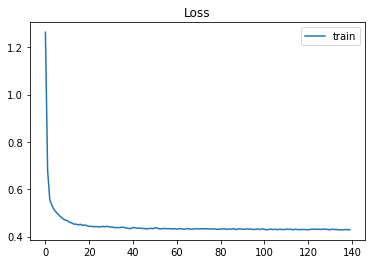

In [20]:
model = Sequential()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), 
                             eps=1e-08, weight_decay=0, amsgrad=False)

loss_func = nn.MSELoss()   
    
    
epoch_train_loss = []

epoch_valid_loss = []

    
for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []    
    
    # for batch in tqdm(trainloader):
    for batch in tqdm(train_loader):
        X, y = batch          
        # print(X)
        y_hat = model(X)
        loss = loss_func(y_hat, y) #rmse
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
        
        # Record the loss and accuracy.
        train_loss.append(loss.item())
        
    train_loss = sum(train_loss) / len(train_loss)
    
    epoch_train_loss.append(train_loss)   
  
    # Print the information.
    print(f"[ Epoch | {epoch + 1:03d}/{n_epochs:03d} ] \
          train_loss = {train_loss:.5f} mean_squared_error = {train_loss:.5f}")
    
print("Defined the build_model and train_model functions.")

import matplotlib.pyplot as plt

# Loss curve
plt.plot(epoch_train_loss)
plt.title('Loss')
plt.legend(['train'])
plt.savefig('loss.png')
plt.show()

In [21]:
model.eval()

# These are used to record information in validation.
test_loss = []

for batch in tqdm(test_loader):
    X, y = batch          
    # print(X)
    y_hat = model(X)
    loss = loss_func(y_hat, y) #rmse
    
    # Record the loss and accuracy.
    test_loss.append(loss.item())
    
    
 # The average loss and accuracy for entire validation set is the average of the recorded values.
test_loss = sum(test_loss) / len(test_loss)

# Print the information.
print(f"test_loss = {test_loss:.5f} mean_squared_error = {test_loss:.5f}")    


test_loss = 3.97807 mean_squared_error = 3.97807
